In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit
from tqdm import tqdm
from cv2 import cv2

In [4]:
numx = 30
numy = 60
x0 = numx // 2
y0 = numy // 2
t0 = 0

## Green's function (before optimizing)

$G(\rho, t) = \Theta (t - \frac{\rho}{v}) (1 - e^{-\frac{t-\rho/v}{\tau_\text{inc}}}) e^{-\frac{t-\rho/v}{\tau_\text{dec}}} e^{-\frac{\rho}{\rho_c}}$

In [5]:
def greens_function_slow(x, y, t, x0, y0, t0, 
                         tau_inc=2.5, 
                         tau_dec=5, 
                         rho_e=5, #8, 
                         v=.5,
                         amp=3):
    
    t = t - t0
    c_x = 20
    c_y = 1
    rho = np.sqrt((c_x * (x - x0)) ** 2 + c_y * (y - y0) ** 2)
    if t <= rho / v:
        return 0.05
    else:
        return amp * (1 - np.exp(-(t - rho / v) / tau_inc)) * np.exp(-(t - rho / v) / tau_dec) * np.exp(-rho / rho_e) + 0.05

In [6]:
dt = 1
dx = 1
dy = 1

trange = np.arange(0, 50, dt)
xrange = np.arange(0, numx, dx)
yrange = np.arange(0, numy, dy)

data_mat = np.zeros((len(trange), len(xrange), len(yrange)))
for k, t in tqdm(enumerate(trange)):
    for i, x in enumerate(xrange):
        for j, y in enumerate(yrange):
            data_mat[k, i, j] = greens_function_slow(x, y, t, x0, y0, t0)

50it [00:00, 118.02it/s]


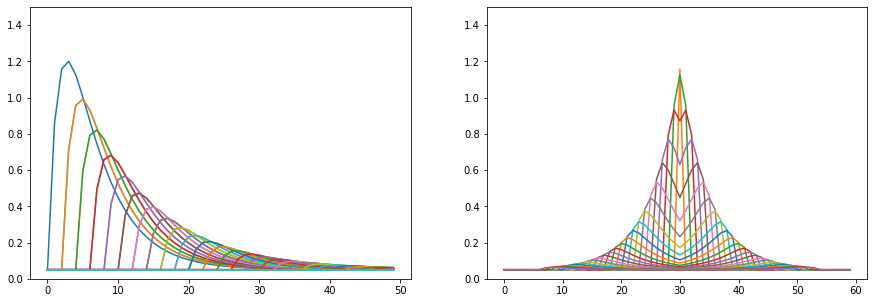

In [7]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(trange, data_mat[:, numx // 2, :])
ax1.set_ylim(0, 1.5)

ax2 = fig.add_subplot(122)
ax2.plot(data_mat[:, numx // 2, :].T[:, ::2])
ax2.set_ylim(0, 1.5)
plt.show()

## Biophysical model

In [8]:
from hydramuscle.model.smc import SMC
from hydramuscle.model.layer import Layer

In [9]:
# Construct muscle sheet
T = 100
dt = 0.01
save_interval=10
smc = SMC(T=T, dt=dt, k_ipr=0.2, s0=100, k_deg=0.01)
layer = Layer(smc, 
              numx=numx, 
              numy=numy, 
              gip3x=0.1, 
              gip3y=2.0, 
              gcx=1000, 
              gcy=1000,
              save_interval=save_interval, 
              active_v_beta=1)

layer.set_stim_pattern(pathway='slow',
                       xmin=14, xmax=16, ymin=29, ymax=31,
                       stim_times=[0])

sol = layer.run(save_all=True)

100%|██████████| 10000/10000 [00:03<00:00, 2768.58it/s]


In [10]:
# Extract longitudinal
calcium = sol[:, :numx * numy].reshape(-1, numx, numy)
ip = sol[:, 3 * numx * numy : 4 * numx * numy].reshape(-1, numx, numy)

calcium_lon = calcium[:, numx // 2, :]
ip_lon = ip[:, numx // 2, :]

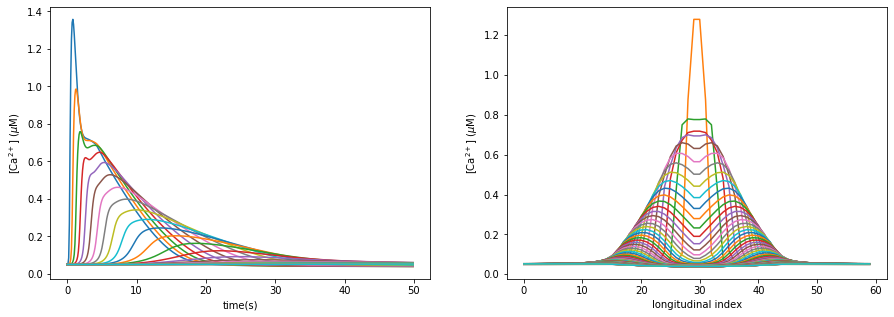

In [11]:
# Plot 

fig = plt.figure(figsize=(15,5))
# Calcium waves
ax11 = fig.add_subplot(121)
ax11.plot(np.arange(0, 50, dt*save_interval), calcium_lon[:500, numy // 2:])
ax11.set_xlabel('time(s)')
ax11.set_ylabel(r'[Ca$^{2+}$] ($\mu$M)')
# Calcium wavefronts
ax12 = fig.add_subplot(122)
ax12.plot(calcium_lon.T[:, ::10])
ax12.set_xlabel('longitudinal index')
ax12.set_ylabel(r'[Ca$^{2+}$] ($\mu$M)')
plt.show()

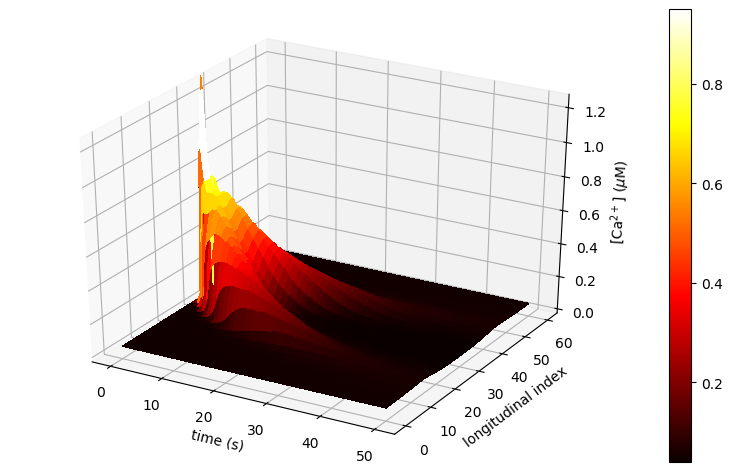

In [12]:
# Plot surface
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')
X = np.outer(np.linspace(0, 50, 500), np.ones(60))
Y = np.outer(np.ones(500), np.linspace(0, 60, 60))
surf = ax.plot_surface(X, Y, calcium_lon[:500], cmap='hot', antialiased=False)
ax.set_zlim(0, 1.25)
ax.set_xlabel('time (s)')
ax.set_ylabel('longitudinal index')
ax.set_zlabel('[Ca$^{2+}$] ($\mu$M)')
fig.colorbar(surf)
plt.savefig('../../results/figures/lon_trace_biophy_slow.pdf', bbox_inches='tight')
plt.show()

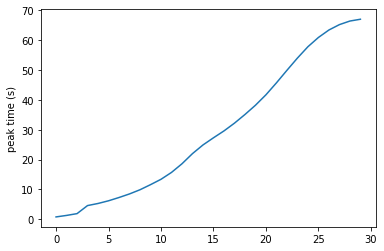

In [13]:
ca_lon_half = calcium_lon[:, numy // 2:]

# Plot the peak arrival time of each element
pk_times = []
for i in range(numy // 2):
    pk_times.append(np.argmax(ca_lon_half[:, i]) * dt * save_interval)

plt.figure()
plt.plot(pk_times)
plt.ylabel('peak time (s)')
plt.show()

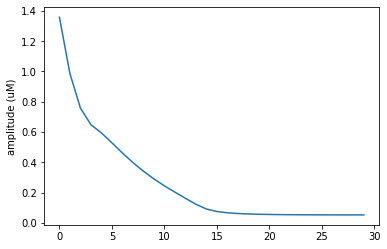

In [14]:
# Plot the amplitude of each element
amps = []
for i in range(numy // 2):
    amps.append(np.max(ca_lon_half[:, i]))

plt.figure()
plt.plot(amps)
plt.ylabel('amplitude (uM)')
plt.show()

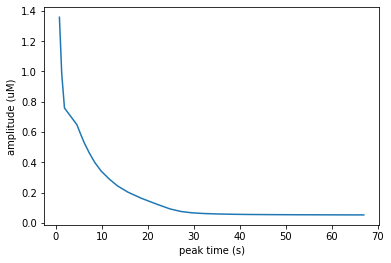

In [15]:
# Plot amplitude v.s. peak times
plt.figure()
plt.plot(pk_times, amps)
plt.xlabel('peak time (s)')
plt.ylabel('amplitude (uM)')
plt.show()

## Fitting

In [16]:
from scipy.optimize import curve_fit

### 1. Fit $\tau_\text{inc}$ and $\tau_\text{dec}$ with the selected trace

In [17]:
select_trace = calcium_lon[:500, numy // 2 + 3]

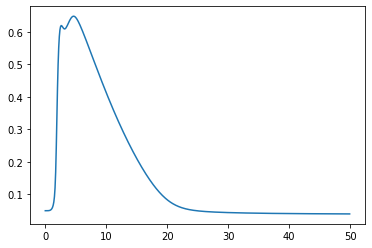

In [18]:
# Have a look ...
plt.figure()
t_seq = np.arange(0, 50, dt*save_interval)
plt.plot(t_seq, select_trace)
plt.show()

#### option 1 : scipy.optimize.curve_fit

In [19]:
# Extract the time scales of increasing and decreasing phases

ind_init = np.argmax(select_trace > 0.055)
select_trace = select_trace[ind_init:]

def func(t, tau_inc, tau_dec, amp_tmp):
    return amp_tmp * (1 - np.exp(-t / tau_inc)) * np.exp(-t / tau_dec) + 0.05

trange = np.arange(0, round((500-ind_init)*0.1, 2), 0.1)
popt, _ = curve_fit(func, trange, select_trace)

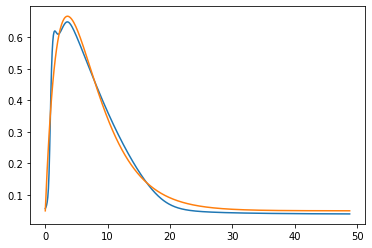

In [20]:
plt.figure()
plt.plot(trange, select_trace)
plt.plot(trange, func(trange, *popt))
plt.show()

In [21]:
print(popt[0], popt[1])

7.645296250135191 4.540142078718715


#### option 2 : fit time scales

In [22]:
select_trace_subtracted = select_trace - 0.05

In [23]:
def calc_time_scales(arr, dt, start_zero=True, thres=0.055):
    
    if not start_zero:
        ind_init = np.argmax(arr > thres)
    else:
        ind_init = 0
    ind_max = np.argmax(arr)
    time_inc = (ind_max - ind_init) * dt
    time_dec = np.inf

    for index, v in enumerate(arr):
        if index > ind_max and v < .005: #max(arr) / np.e:
            time_dec = (index - ind_max) * dt
            break
            
    return time_inc, time_dec

time_inc, time_dec = calc_time_scales(select_trace_subtracted, dt=dt * save_interval, start_zero=True)

In [24]:
print('increasing time is ', round(time_inc, 4))
print('decreasing time is ', round(time_dec, 4))

increasing time is  3.5
decreasing time is  18.6


In [25]:
# Formulate the trace of the select point
def gf_select(tau_inc, tau_dec, t):
    return (1 - np.exp(- t / tau_inc)) * np.exp(- t / tau_dec)

In [26]:
# Sweep the parameters to fit the time scales
def loss(t_inc, t_dec, time_inc, time_dec):
    return (t_inc / time_inc - 1) ** 2 + (t_dec / time_dec - 1) ** 2

tau_inc_best = None
tau_dec_best = None
t_inc_best = None
t_dec_best = None
loss_best = np.inf

for tau_inc in tqdm(np.arange(0.1, 10.1, 0.1)):
    for tau_dec in np.arange(0.1, 10.1, 0.1):
        sim_trace = []
        for t in np.arange(0, 50, 0.1):
            sim_trace.append(gf_select(tau_inc, tau_dec, t))
        t_inc, t_dec = calc_time_scales(sim_trace, 0.1, thres=0)
        loss_tmp = loss(t_inc, t_dec, time_inc, time_dec)
    
        if loss_tmp < loss_best:
            loss_best = loss_tmp
            tau_inc_best, tau_dec_best = tau_inc, tau_dec
            t_inc_best, t_dec_best = t_inc, t_dec

100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


In [27]:
print(tau_inc_best, tau_dec_best)

9.1 4.2


In [28]:
# Plot the best simulated trace
sim_trace = []
for t in np.arange(0, 50, 0.1):
    sim_trace.append(gf_select(tau_inc_best, tau_dec_best, t))

amp_tmp = max(select_trace_subtracted) / max(sim_trace) 
sim_trace = [x * amp_tmp + 0.05 for x in sim_trace]

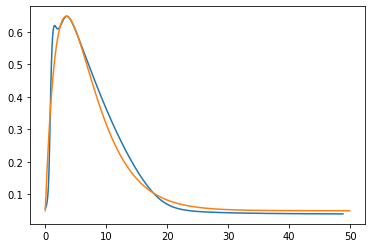

In [29]:
plt.figure()
plt.plot(trange, select_trace)
plt.plot(np.arange(0, 50, .1), sim_trace)
plt.show()

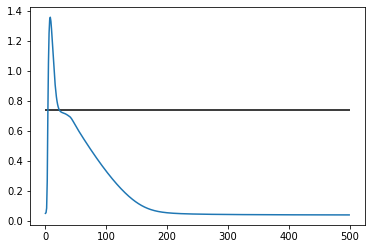

In [30]:
# Ignore the absurd peak
plt.figure()
plt.plot(calcium_lon[:500, numy//2])
plt.hlines(0.74, 0, 500)
plt.show()

In [31]:
amp_max_appt = 0.74

In [32]:
# Compute the amp_best with the first trace
sim_trace = []
for t in np.arange(0, 50, 0.1):
    sim_trace.append(gf_select(tau_inc_best, tau_dec_best, t))
    
first_trace = calcium_lon[:500, numy // 2]
amp_best = amp_max_appt / max(sim_trace) 
print(amp_best)

5.332879041715078


In [33]:
# tau_inc_best = popt[0]
# tau_dec_best = popt[1]

### 2. Fit $v, \rho_e, c_x$

In [34]:
# Measure the time lag and amplitude difference between two selected trace
select_trace_1 = calcium[:500, numx // 2, numy // 2]
select_trace_2 = calcium[:500, numx // 2, numy // 2 + 13]
select_trace_2_x = calcium[:500, numx // 2 + 2, numy // 2]

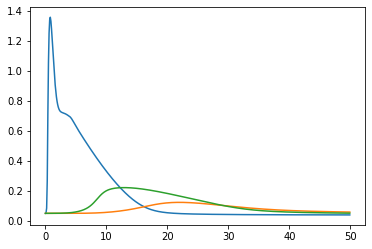

In [35]:
# Have a look
plt.figure()
plt.plot(np.arange(0, 50, 0.1), select_trace_1)
plt.plot(np.arange(0, 50, 0.1), select_trace_2)
plt.plot(np.arange(0, 50, 0.1), select_trace_2_x)
plt.show()

In [36]:
def calc_diffs(last_trace, first_trace, dt, amp_metric='abs', real_curve=False):
    t_lag = np.argmax(last_trace) * dt - np.argmax(first_trace) * dt
    
    if real_curve:
        amp_max = amp_max_appt
    else:
        amp_max = max(first_trace)
    
    if amp_metric == 'abs':
        a_diff = amp_max - max(last_trace)
    elif amp_metric == 'ratio':
        a_diff = max(last_trace) / amp_max
    return t_lag, a_diff

time_lag, amp_diff = calc_diffs(select_trace_2, select_trace_1, dt*save_interval, amp_metric='ratio', real_curve=True)
time_lag_x, amp_diff_x = calc_diffs(select_trace_2_x, select_trace_1, dt*save_interval, amp_metric='ratio', real_curve=True)

In [37]:
print(time_lag, amp_diff)

21.2 0.16645052366446


In [38]:
print(time_lag_x, amp_diff_x)

12.1 0.29925079661644216


In [39]:
# Formulate the Green's function for the muscle sheet
def greens_function_2d(x, y, t, x0, y0, t0, tau_inc, tau_dec, amp, v, rho_e, c_x):
    
    t = t - t0
    rho = np.sqrt((c_x * (x - x0)) ** 2 + (y - y0) ** 2)
    if t <= rho / v:
        return 0.05
    else:
        return amp * (1 - np.exp(-(t - rho / v) / tau_inc)) * np.exp(-(t - rho / v) / tau_dec) * np.exp(-rho / rho_e) + 0.05

In [40]:
# Sweep the parameters to fit
def loss2(t_lag, time_lag, a_diff, amp_diff):
    return (t_lag / time_lag - 1) ** 2 + (a_diff / amp_diff - 1) ** 2

v_best = None
rho_e_best = None
t_lag_best = None
a_diff_best = None
t_lag_x_best = None
a_diff_x_best = None
c_x_best = None
loss2_best = np.inf

In [41]:
for v in tqdm(np.arange(.1, 1, .1)):
    for rho_e in np.arange(.1, 10, .1):
        for c_x in np.arange(.1, 5, .1):
            sim_last_trace = []
            sim_last_trace_x = []
            sim_first_trace = []
            
            for t in np.arange(0, 50, 0.1):
                sim_first_trace.append(greens_function_2d(numx//2, numy//2, t, numx//2, numy//2, 0, tau_inc_best, tau_dec_best, amp_best, v, rho_e, c_x))
                sim_last_trace.append(greens_function_2d(numx//2, numy//2+13, t, numx//2, numy//2, 0, tau_inc_best, tau_dec_best, amp_best, v, rho_e, c_x))
                sim_last_trace_x.append(greens_function_2d(numx//2+2, numy//2, t, numx//2, numy//2, 0, tau_inc_best, tau_dec_best, amp_best, v, rho_e, c_x))
                
            t_lag, a_diff = calc_diffs(sim_last_trace, sim_first_trace, 0.1, amp_metric='ratio')
            t_lag_x, a_diff_x = calc_diffs(sim_last_trace_x, sim_first_trace, 0.1, amp_metric='ratio')
            loss2_tmp = loss2(t_lag, time_lag, a_diff, amp_diff) + loss2(t_lag_x, time_lag_x, a_diff_x, amp_diff_x)

            if loss2_tmp < loss2_best:
                loss2_best = loss2_tmp
                rho_e_best, v_best, c_x_best = rho_e, v, c_x
                t_lag_best, a_diff_best = t_lag, a_diff
                t_lag_x_best, a_diff_x_best = t_lag_x, a_diff_x

100%|██████████| 9/9 [06:01<00:00, 40.19s/it]


In [42]:
print(rho_e_best, v_best, c_x_best)

5.7 0.6 3.8000000000000003


In [43]:
print(t_lag_best, a_diff_best)

21.6 0.1590414057960333


In [44]:
print(t_lag_x_best, a_diff_x_best)

12.600000000000001 0.3102228522805013


In [45]:
sim_last_trace = []
sim_last_trace_x = []
sim_first_trace = []
for t in np.arange(0, 50, 0.1):
    sim_first_trace.append(greens_function_2d(numx//2, numy//2, t, numx//2, numy//2, 0, tau_inc_best, tau_dec_best, amp_best, v_best, rho_e_best, c_x_best))
    sim_last_trace.append(greens_function_2d(numx//2, numy//2+13, t, numx//2, numy//2, 0, tau_inc_best, tau_dec_best, amp_best, v_best, rho_e_best, c_x_best))
    sim_last_trace_x.append(greens_function_2d(numx//2+2, numy//2, t, numx//2, numy//2, 0, tau_inc_best, tau_dec_best, amp_best, v_best, rho_e_best, c_x_best))

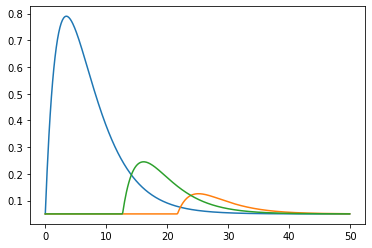

In [46]:
plt.figure()
plt.plot(np.arange(0, 50, 0.1), sim_first_trace)
plt.plot(np.arange(0, 50, 0.1), sim_last_trace)
plt.plot(np.arange(0, 50, 0.1), sim_last_trace_x)
plt.show()

In [47]:
# Plot the final simulation results
dt = 0.1
dx = 1
dy = 1

trange = np.arange(0, 50, dt)
xrange = np.arange(0, numx, dx)
yrange = np.arange(0, numy, dy)

data_mat = np.zeros((len(trange), len(xrange), len(yrange)))
for k, t in tqdm(enumerate(trange)):
    for i, x in enumerate(xrange):
        for j, y in enumerate(yrange):
            data_mat[k, i, j] = greens_function_2d(x, y, t, x0, y0, t0, tau_inc_best, tau_dec_best, amp_best, v_best, rho_e_best, c_x_best)

500it [00:03, 159.84it/s]


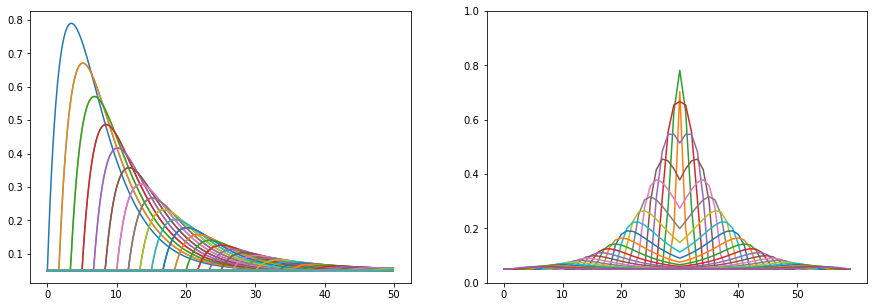

In [48]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(trange, data_mat[:, data_mat.shape[1] // 2, ::])
# ax1.set_xticks(range(0, len(trange), 20))
# ax1.set_xticklabels([round(x, 2) for x in trange[::20]])

ax2 = fig.add_subplot(122)
ax2.plot(data_mat[::20, data_mat.shape[1] // 2, ::].T)
ax2.set_ylim(0, 1)
ax2.set_xticks(range(0, len(yrange), 10))
ax2.set_xticklabels([int(y) for y in yrange[::10]])
plt.show()

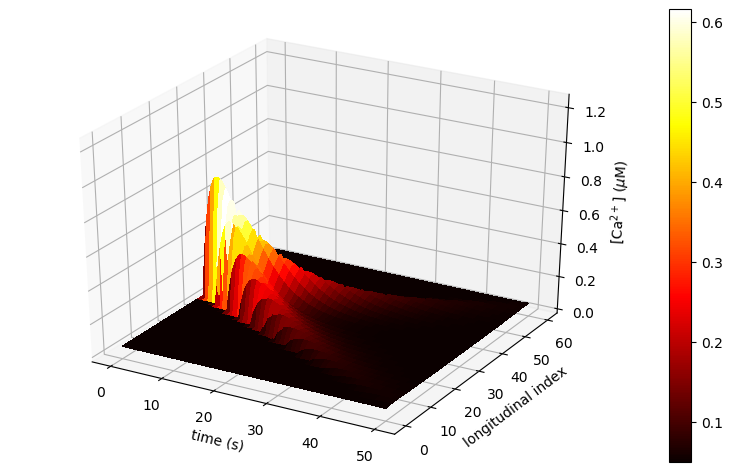

In [50]:
# Plot surface
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')
X = np.outer(np.linspace(0, 50, 500), np.ones(60))
Y = np.outer(np.ones(500), np.linspace(0, 60, 60))
surf = ax.plot_surface(X, Y, data_mat[:, numx//2, :], cmap='hot', antialiased=False)
ax.set_zlim(0, 1.25)
ax.set_xlabel('time (s)')
ax.set_ylabel('longitudinal index')
ax.set_zlabel('[Ca$^{2+}$] ($\mu$M)')
fig.colorbar(surf)
plt.savefig('../../results/figures/lon_trace_gf_slow.pdf', bbox_inches='tight')
plt.show()